In [126]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [164]:
# Data Loading
df = pd.read_csv('./Data/inverse_data.csv')

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2462 non-null   object 
 1   Open    2462 non-null   int64  
 2   High    2462 non-null   int64  
 3   Low     2462 non-null   int64  
 4   Close   2462 non-null   int64  
 5   Volume  2462 non-null   int64  
 6   Change  2462 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 134.8+ KB


In [171]:
# MinMax 스케일러 이용한 데이터 정규화 
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in scale_cols:
    scaled_value = scaler.fit_transform(df[[col]])
    df[col] = scaled_value

# 학습 데이터, 테스트 데이터 분리
df.set_index('Date', inplace=True)
train_set = df[:'2017-12-31']
test_set = df['2019-01-01':]
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2013-01-04,0.661738,0.644504,0.679924,0.659401,0.039956,0.006892
2013-01-07,0.670055,0.651596,0.688447,0.658492,0.031559,-0.000684
2013-01-08,0.675601,0.655142,0.691288,0.673025,0.038526,0.010959
2013-01-09,0.682994,0.661348,0.696970,0.678474,0.042234,0.004065
2013-01-10,0.688540,0.664894,0.695076,0.665758,0.082208,-0.009447


In [172]:
# seq_length 만큼 데이터 셋 묶어준다
seq_length = 7
batch = 100

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)
print(f"trainX:{trainX.shape}, testX:{testX.shape}, trainY:{trainY.shape}, testY:{testY.shape}")

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

trainX:(1220, 7, 6), testX:(984, 7, 6), trainY:(1220, 1), testY:(984, 1)


In [178]:
# HyperParameter
data_dim = 6
hidden_dim = 25
output_dim = 1 
learning_rate = 0.01
nb_epochs = 1000

class LSTM(nn.Module):
    # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, 
                            num_layers=layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_dim))
        c_0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_dim))
           
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_dim)

        out = self.fc(h_out)

        return out

In [179]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 1, patience = 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            #model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
            # cost 계산
            loss = criterion(outputs, y_train)                 
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss.item()/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break

    return model.eval(), train_hist

In [180]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 2, patience = 1)

Epoch: 0000 train loss : 0.0032
Epoch: 0002 train loss : 0.0002
Epoch: 0004 train loss : 0.0001
Epoch: 0006 train loss : 0.0001
Epoch: 0008 train loss : 0.0001
Epoch: 0010 train loss : 0.0001

 Early Stopping


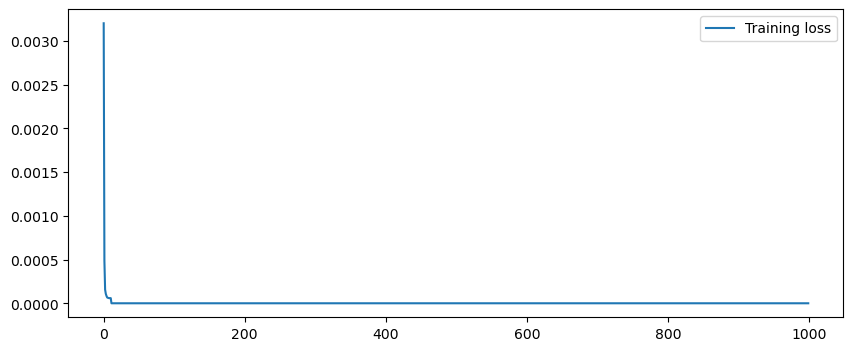

In [181]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()